In [1]:
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import ocelot as oc
import ocelot.gui as ocg

import cheetah
import ARESlatticeStage3v1_9 as aresstuff
from cheetah import utils

math_op.py: module Numba is not installed. Install it if you want speed up correlation calculations


[INFO    ] : : beam.py: module NUMBA is not installed. Install it to speed up calculation
[INFO    ] : : : : : : : : high_order.py: module NUMBA is not installed. Install it to speed up calculation
[INFO    ] radiation_py.py: module NUMBA is not installed. Install it to speed up calculation
[INFO    ] radiation_py.py: module NUMBA is not installed. Install it to speed up calculation
[INFO    ] csr.py: module NUMBA is not installed. Install it to speed up calculation
[INFO    ] csr.py: module PYFFTW is not installed. Install it to speed up calculation.
[INFO    ] csr.py: module NUMEXPR is not installed. Install it to speed up calculation
[INFO    ] wake3D.py: module NUMBA is not installed. Install it to speed up calculation


initializing ocelot...
import: module NUMBA is not installed. Install it to speed up calculation
import: module PYFFTW is not installed. Install it to speed up calculation
import: module NUMEXPR is not installed. Install it to speed up calculation


In [2]:
print(f"Ocelot: {oc.generate_parray(nparticles=int(1e+5), sigma_x=175e-6, sigma_y=175e-6).rparticles.shape}")
print(f"Cheetah: {cheetah.ParticleBeam.from_parameters(n=int(1e+5), sigma_x=175e-6, sigma_y=175e-6).particles.shape}")

Ocelot: (6, 100000)
Cheetah: torch.Size([100000, 7])


In [3]:
actuator_values = np.array([4.14, -6.94, 2.99, 0, 0])

z = 6.654039999999998 / 6.654039999999998. Applied: Ocelot: 0.000131977350882418 / 0.00010829595870973273
Cheetah: 4.1910556092261686e-07 / 5.109893095323059e-07


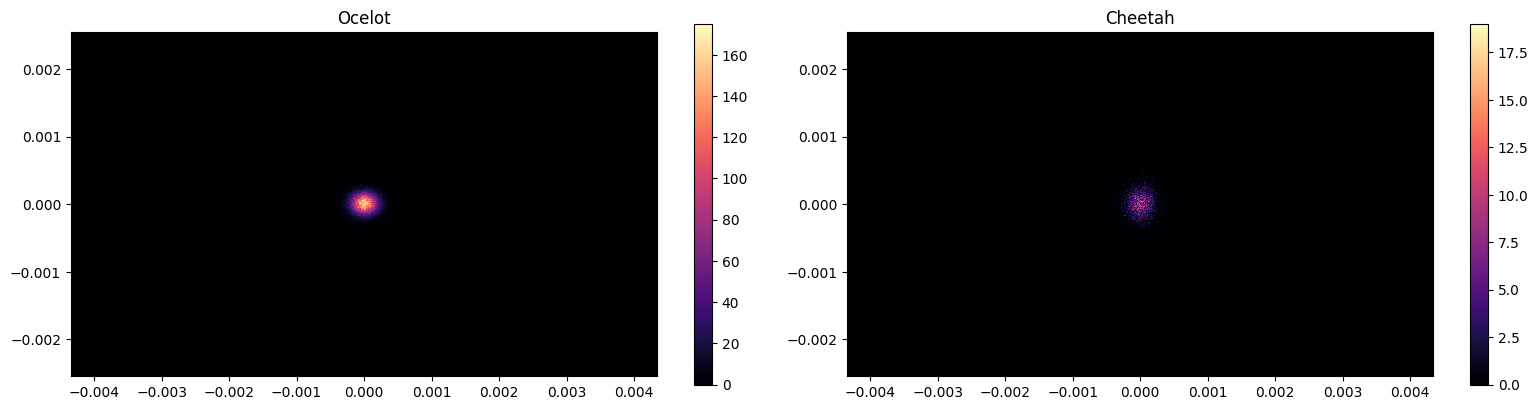

In [4]:
plt.figure(figsize=(16,4))
binning = 4
screen_resolution = (int(2448 / binning), int(2040 / binning))
meter_per_pixel = (3.5488e-6 * binning, 2.5003e-6 * binning)
screen_bin_edges = (np.linspace(-screen_resolution[0]*meter_per_pixel[0]/2,
                                screen_resolution[0]*meter_per_pixel[0]/2,
                                screen_resolution[0]+1),
                    np.linspace(-screen_resolution[1]*meter_per_pixel[1]/2,
                                screen_resolution[1]*meter_per_pixel[1]/2,
                                screen_resolution[1]+1))
screen_range = [(-screen_resolution[0] * meter_per_pixel[0] / 2,
                 screen_resolution[0] * meter_per_pixel[0] / 2),
                (-screen_resolution[1] * meter_per_pixel[1] / 2,
                 screen_resolution[1] * meter_per_pixel[1] / 2)]

cell = utils.subcell_of_ocelot(aresstuff.cell, "AREASOLA1", "Drift_ARMRBSCR1")
aresstuff.areamqzm1.k1 = actuator_values[0]
aresstuff.areamqzm2.k1 = actuator_values[1]
aresstuff.areamqzm3.k1 = actuator_values[2]
aresstuff.areamcvm1.angle = actuator_values[3]
aresstuff.areamchm1.angle = actuator_values[4]
# cell = [oc.Drift(l=3.0), oc.Quadrupole(l=1, k1=0), oc.Drift(l=0), oc.Drift(l=3)]
# cell = [oc.Drift(l=3.0)]

lattice = oc.MagneticLattice(cell)
navigator = oc.Navigator(lattice)
# particles = oc.generate_parray(nparticles=int(1e+5), sigma_x=175e-6, sigma_y=175e-6)
particles = oc.generate_parray(nparticles=int(1e+5), sigma_x=175e-6, sigma_y=175e-6, sigma_p=0., chirp=0., energy=0.1, sigma_tau=0.0)
particle_array = deepcopy(particles)
_, particles = oc.track(lattice, particles, navigator)
image, _, _ = np.histogram2d(particles.x(), particles.y(),
                             bins=(screen_resolution[0],screen_resolution[1]),
                             range=screen_range)
image = np.flipud(image.T)
print(f"Ocelot: {particles.x().std()} / {particles.y().std()}")

screen_extent = (-screen_resolution[0] * meter_per_pixel[0] / 2, screen_resolution[0] * meter_per_pixel[0] / 2,
                 -screen_resolution[1] * meter_per_pixel[1] / 2, screen_resolution[1] * meter_per_pixel[1] / 2)

plt.subplot(121)
plt.title("Ocelot")
plt.imshow(image, cmap="magma", interpolation="None", extent=screen_extent)
plt.colorbar()

# particles_cheetah = cheetah.generate_particles(n=int(1e+5), sigma_x=175e-6, sigma_y=175e-6)
particles_cheetah = cheetah.ParticleBeam.from_ocelot(particle_array)
segment = cheetah.Segment.from_ocelot(cell)
segment.AREABSCR1.is_active = True
_ = segment(particles_cheetah)
image = segment.AREABSCR1.reading
segment.AREABSCR1.is_active = False
particles_cheetah = segment(particles_cheetah)
print(f"Cheetah: {particles_cheetah.mu_x} / {particles_cheetah.mu_y}")

plt.subplot(122)
plt.title("Cheetah")
plt.imshow(image, cmap="magma", interpolation="None", extent=screen_extent)
plt.colorbar()

plt.tight_layout()
plt.show()

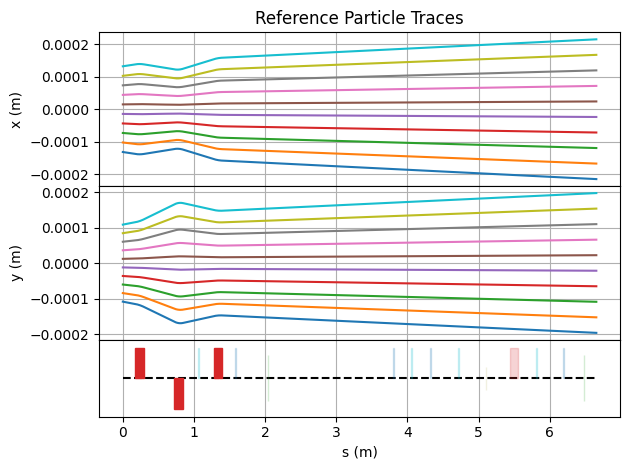

In [5]:
segment.plot_overview(beam=particles_cheetah)

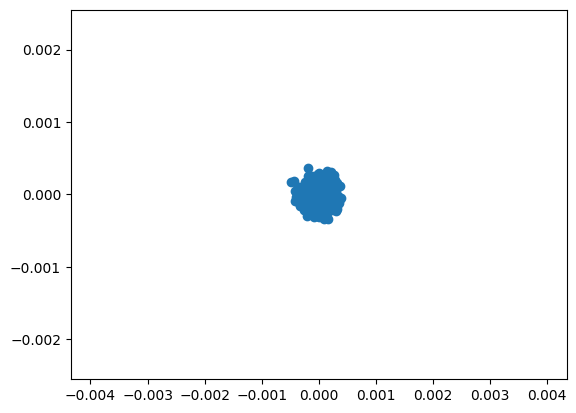

In [6]:
plt.scatter(particles_cheetah.particles[:1000,0], particles_cheetah.particles[:1000,2])
plt.xlim(-screen_resolution[0] * meter_per_pixel[0] / 2, screen_resolution[0] * meter_per_pixel[0] / 2)
plt.ylim(-screen_resolution[1] * meter_per_pixel[1] / 2, screen_resolution[1] * meter_per_pixel[1] / 2)
plt.show()

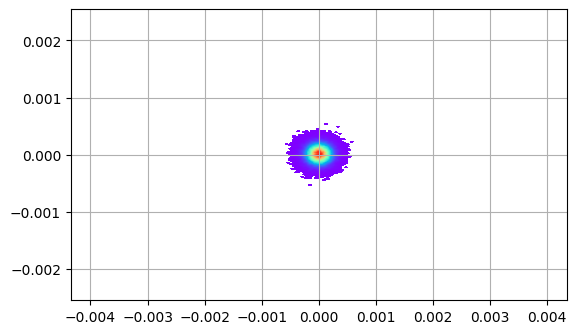

In [7]:
ocg.show_density(particles.x(), particles.y(), limits=[(-screen_resolution[0] * meter_per_pixel[0] / 2,
                                                        screen_resolution[0] * meter_per_pixel[0] / 2),
                                                       (-screen_resolution[1] * meter_per_pixel[1] / 2,
                                                       screen_resolution[1] * meter_per_pixel[1] / 2)])
plt.gca().set_aspect("equal")
plt.show()